# Relax Challenge

(I will put my findings here at the top. The code and thought process while I was working is below in the notebook. )

### Goal:
Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .


### Summary:


From my work, the factors which best predicted future user adoption were:

* how recently a user has logged in (last_session_creation_time)
* the organization they belong to (org_id)
* how long they have been a member (engineered out of 'creation_time')

### Brief Outline of Work:

The first thing I wanted to do was create a dataframe with only "adopted users". This was a bit trickier than I originally thought it would be due to the 7 day window condition. I'm sure there are much quicker/more elegant ways to do it than I did here, but trying to follow the time guidelines, I just stuck to techniques I was more comfortable with. Also, I'll admit I'm not sure I subsetted it 100% accurately, but I was spending a decent bit of time on that so I felt moving on to things like  correlation matricies and feature importances was a better use of time. I can always go back and review/clean up the code if that is necessary. 

Eventually I was able to engineer the main feature I wanted (whether or not the user was an "adopted user"). I also made a couple extra features such as how long a user has been a member, and encoded the 'creation_source' feature.

I then used the heatmap/correlation matrix as a heuristic and made a very quick random forest model to extract feature importances from. I used a 70/30 train test split, and it actually had an 84.5% accuracy score, so I felt like the feature importances there held some weight, even if all the work wasn't extremely sound. I also should admit I spent closer to 3-4 hours instead of the 1-2 recommended on the guidelines. 

### Visuals
These were the main two contibutors to my reasioning behind the features I listed. 

<AxesSubplot:>

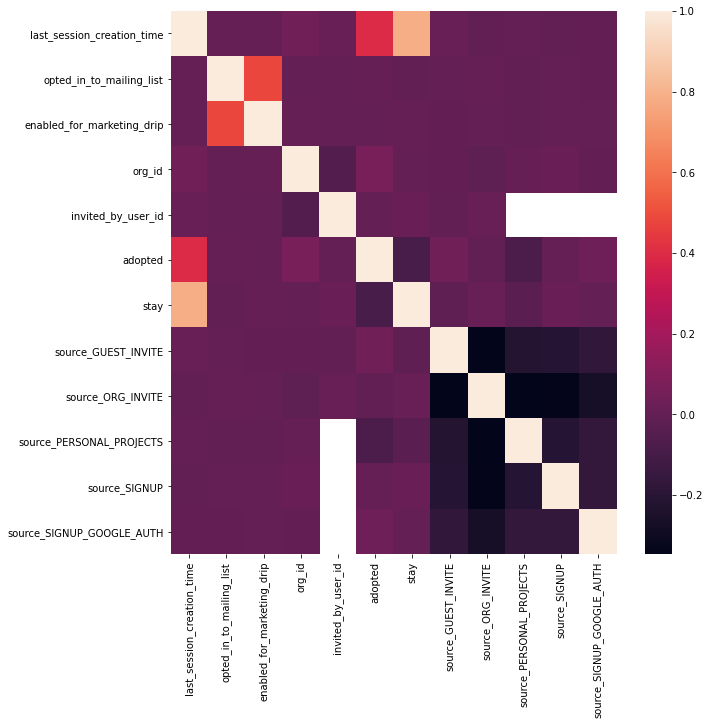

In [59]:
plt.figure(figsize = (10,10))
sns.heatmap(factors_encoded.corr())

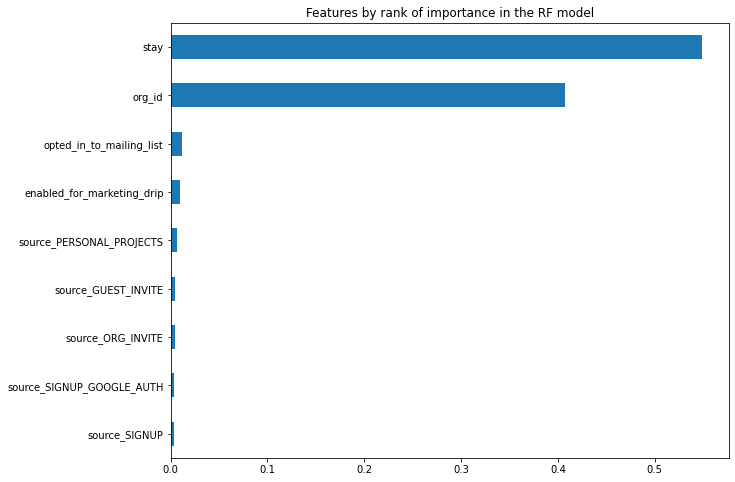

In [76]:
rf_features =  pd.Series(rf.feature_importances_, index = X.columns)
rf_features.sort_values().plot(kind='barh', figsize=(10,8))
plt.title('Features by rank of importance in the RF model')
plt.show()

# Here is the work described above

#### An "adopted user" is a user who has logged into the product on three separate days in at least one seven-day period. 

#### Identify which factors predict future user adoption. 


### Initial Thoughts

The first thing it seems we should do is to create a dataframe with only "adopted users". I think we can do this by grouping by user id in the records table (or making a counter object?) and then subsetting the users table to only include those with sufficient appearances. 


In [7]:
users = pd.read_csv("takehome_users.csv")
record = pd.read_csv("takehome_user_engagement.csv")

Before jumping in, lets take a quick look at our data. 

## Users

In [8]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


## Usage Records

In [10]:
record.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [12]:
record['time_stamp'] = pd.to_datetime(record.time_stamp, infer_datetime_format = True)

In [13]:
min(record.time_stamp)

Timestamp('2012-05-31 08:20:06')

In [14]:
max(record.time_stamp)

Timestamp('2014-06-06 14:58:50')

In [15]:
days = record.sort_values('time_stamp')

In [16]:
dates = sorted([x.date() for x in days.time_stamp])

In [17]:
#dates

In [18]:
days['Date'] = dates

In [19]:
days

,time_stamp,user_id,visited,Date
178140,2012-05-31 08:20:06,10012,1,2012-05-31
59486,2012-05-31 15:47:36,3428,1,2012-05-31
175638,2012-05-31 17:19:37,9899,1,2012-05-31
26821,2012-05-31 21:58:33,1693,1,2012-05-31
109716,2012-06-01 00:17:30,6102,1,2012-06-01
...,...,...,...,...
84316,2014-06-04 23:32:13,4625,1,2014-06-04
162633,2014-06-04 23:34:04,9325,1,2014-06-04
168409,2014-06-04 23:46:31,9558,1,2014-06-04
6053,2014-06-04 23:56:26,341,1,2014-06-04


In [68]:
#days.sort_values('Date')

,time_stamp,user_id,visited,Date
1,2013-11-15 03:45:04,2,1,2012-05-31
2,2013-11-29 03:45:04,2,1,2012-05-31
0,2014-04-22 03:53:30,1,1,2012-05-31
3,2013-12-09 03:45:04,2,1,2012-05-31
5,2013-12-31 03:45:04,2,1,2012-06-01
...,...,...,...,...
207587,2014-03-15 00:48:14,11969,1,2014-06-04
207667,2013-07-01 11:10:11,11975,1,2014-06-04
207864,2013-03-06 01:53:48,11981,1,2014-06-04
207586,2014-03-14 00:48:14,11969,1,2014-06-04


In [21]:
days

,time_stamp,user_id,visited,Date
178140,2012-05-31 08:20:06,10012,1,2012-05-31
59486,2012-05-31 15:47:36,3428,1,2012-05-31
175638,2012-05-31 17:19:37,9899,1,2012-05-31
26821,2012-05-31 21:58:33,1693,1,2012-05-31
109716,2012-06-01 00:17:30,6102,1,2012-06-01
...,...,...,...,...
84316,2014-06-04 23:32:13,4625,1,2014-06-04
162633,2014-06-04 23:34:04,9325,1,2014-06-04
168409,2014-06-04 23:46:31,9558,1,2014-06-04
6053,2014-06-04 23:56:26,341,1,2014-06-04


In [20]:
min(days.index)

0

In [22]:
dia = sorted(list(days.index.unique()))

In [23]:
dates = days.Date.sort_values()

In [24]:
idx = dates.unique()

In [25]:
adopteds = set()
low = dates[0]
for i in range(2):
    low = idx[i]
    #up = low + pd.DateTime(7, unit='D')
    up = idx[i+7]
    #up = low + 7
    window = days[np.logical_and(days.Date<up,days.Date>= low)]

In [26]:
print(window)

                time_stamp  user_id  visited        Date
109716 2012-06-01 00:17:30     6102        1  2012-06-01
200931 2012-06-01 01:42:31    11430        1  2012-06-01
32373  2012-06-01 13:14:18     1995        1  2012-06-01
179759 2012-06-01 14:30:38    10163        1  2012-06-01
140780 2012-06-01 20:02:35     8068        1  2012-06-01
...                    ...      ...      ...         ...
43837  2012-06-07 14:15:15     2583        1  2012-06-07
191059 2012-06-07 15:41:54    10816        1  2012-06-07
187526 2012-06-07 15:46:42    10624        1  2012-06-07
81904  2012-06-07 21:01:35     4541        1  2012-06-07
180211 2012-06-07 23:52:39    10215        1  2012-06-07

[64 rows x 4 columns]


Great, this is what we wanted

adopteds

In [28]:
for i in range(729):
    low = idx[i]
    #up = low + pd.DateTime(7, unit='D')
    up = idx[i+7]
    #up = low + 7
    window = days[np.logical_and(days.Date<up,days.Date>= low)]
    df = pd.DataFrame(window.user_id.value_counts())   
    adds = [list(df.index),list(df.user_id)]
    i = len([x for x in adds[1] if x >=3])
    ids = adds[0][:i]
    for x in ids:
        adopteds.add(x)
    
#print(adds[0][:i])

In [31]:
len(adopteds)

1602

In [29]:
data = users[users.object_id.isin(adopteds)]

In [30]:
data

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,33,2014-03-11 06:29:09,Araujo Jos�,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN
...,...,...,...,...,...,...,...,...,...,...
11964,11965,2014-04-25 07:17:35,Storey Lewis,LewisStorey@cuvox.de,GUEST_INVITE,1.400657e+09,0,0,65,11251.0
11966,11967,2014-01-12 08:12:37,Barbosa Pedro,PedroFernandesBarbosa@gmail.com,GUEST_INVITE,1.401524e+09,0,0,15,5688.0
11968,11969,2013-06-01 00:48:14,Dickinson Aidan,AidanDickinson@hotmail.com,GUEST_INVITE,1.401411e+09,1,1,52,6647.0
11974,11975,2013-03-23 11:10:11,Daecher J�rgen,JurgenDaecher@gustr.com,GUEST_INVITE,1.400757e+09,1,0,31,6410.0


In [32]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [144]:
#path = './'

In [146]:
#save_file(data, 'adoptedusers.csv',path)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./adoptedusers.csv"


In [33]:
data.corr()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,1.000000,-0.012527,-0.021495,-0.009169,0.005952,0.056889
last_session_creation_time,-0.012527,1.000000,-0.003494,-0.023619,-0.007215,0.004037
opted_in_to_mailing_list,-0.021495,-0.003494,1.000000,0.484210,-0.027165,0.029774
enabled_for_marketing_drip,-0.009169,-0.023619,0.484210,1.000000,-0.026180,-0.004120
org_id,0.005952,-0.007215,-0.027165,-0.026180,1.000000,-0.074284
invited_by_user_id,0.056889,0.004037,0.029774,-0.004120,-0.074284,1.000000


In [34]:
import seaborn as sns

<AxesSubplot:>

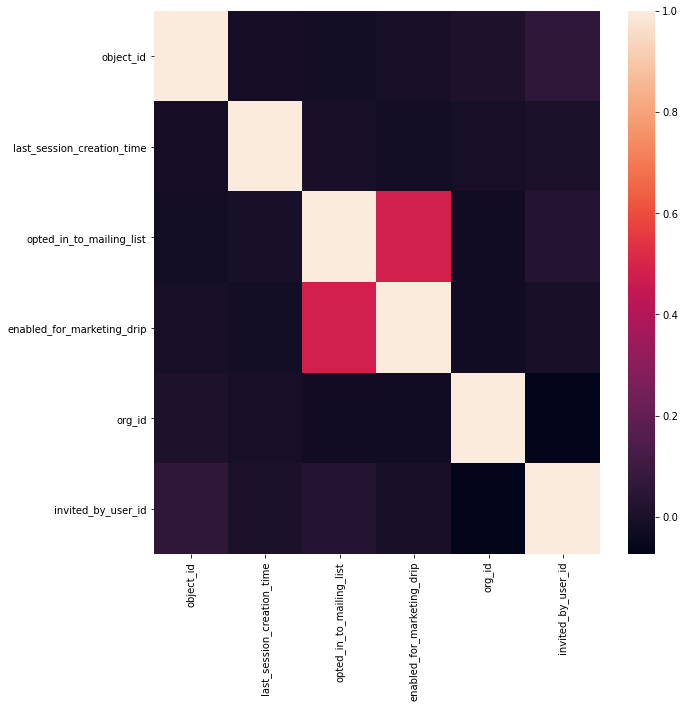

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr())

I dont see anything too promising yet. Lets incorporate some encoding

In [36]:
users['adopted'] = [1 if x in adopteds else 0 for x in list(users.object_id)]

In [37]:
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


<AxesSubplot:>

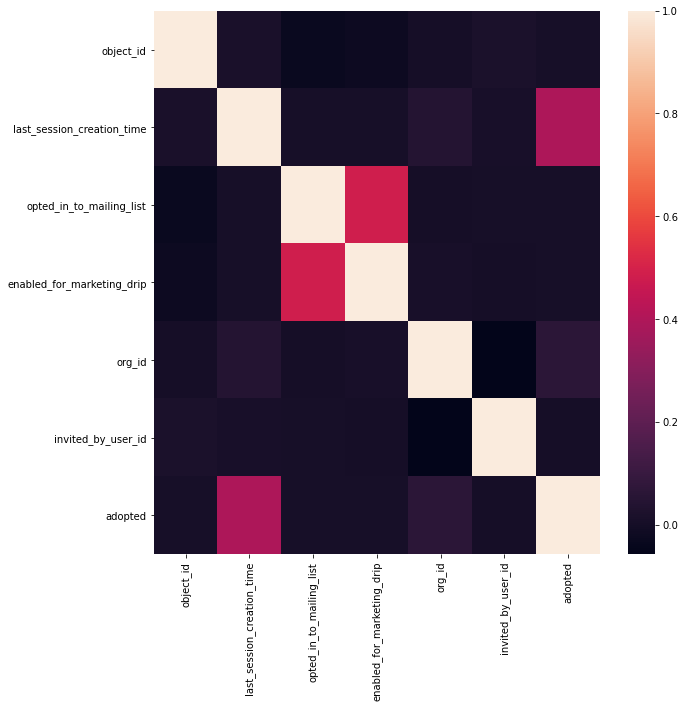

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(users.corr())

In [39]:
users.corr()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,1.000000,0.015238,-0.032370,-0.022040,0.004110,0.018699,0.005750
last_session_creation_time,0.015238,1.000000,0.006590,0.008035,0.042203,0.011874,0.396550
opted_in_to_mailing_list,-0.032370,0.006590,1.000000,0.483529,0.003432,0.004699,0.008097
enabled_for_marketing_drip,-0.022040,0.008035,0.483529,1.000000,0.009275,0.003687,0.004653
org_id,0.004110,0.042203,0.003432,0.009275,1.000000,-0.057780,0.064523
invited_by_user_id,0.018699,0.011874,0.004699,0.003687,-0.057780,1.000000,0.000675
adopted,0.005750,0.396550,0.008097,0.004653,0.064523,0.000675,1.000000


last_session create time is corr


In [ ]:
#y = users.drop

In [155]:
#users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


There are 2 ways I was interpreting this, one was trying to predict future user adoption as in, new users becoming adopted users. This would eliminate things like "last_session_create_time" as predictive features. Then, I realized it could also be interpreted as new AND existing (but not adopted) users becoming adopted users. 

Let's drop columns which don't have anything to do with it either way, such as email, name, ID. Creation time and last session creation time (time of last login) both could be relevant if we are considering the second scenario.

In [40]:
factors = users.drop(columns = ['email','name','object_id'])

In [41]:
factors.dtypes

creation_time                  object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                         int64
dtype: object

I didn't want to do drop_first with the encoding as all 5 creation sources (heuristically) seemed to be decent candidates for predictive features. 

In [42]:
factors['creation_time'] = pd.to_datetime(factors['creation_time'],infer_datetime_format = True)

In [43]:
factors.dtypes

creation_time                 datetime64[ns]
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopted                                int64
dtype: object

In [44]:
max(factors.creation_time)

Timestamp('2014-05-30 23:59:19')

In [45]:
import datetime as dt

mx = min(factors.creation_time)

# get a datetime that is equal to epoch
epoch = mx

stay = [(d - epoch) for d in factors.creation_time]
#stay.total_seconds()

In [47]:
factors['stay'] = stay

In [48]:
factors['stay'] = factors['stay'].dt.total_seconds()

In [49]:
factors

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,stay
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,59713803.0
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,46062097.0
2,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,25309885.0
3,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,30698761.0
4,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,19992653.0
...,...,...,...,...,...,...,...,...,...
11995,2013-09-06 06:14:15,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0,40023048.0
11996,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0,19417510.0
11997,2014-04-27 12:45:16,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0,60177709.0
11998,2012-05-31 11:55:59,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,40352.0


In [50]:
factors['stay'] = factors.stay/(3600*24)

In [51]:
factors

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,stay
0,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,691.131979
1,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,533.126123
2,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,292.938484
3,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,355.309734
4,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,231.396447
...,...,...,...,...,...,...,...,...,...
11995,2013-09-06 06:14:15,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0,463.229722
11996,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0,224.739699
11997,2014-04-27 12:45:16,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0,696.501262
11998,2012-05-31 11:55:59,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,0.467037


In [52]:
factors.drop(columns = ['creation_time'],inplace = True)

In [53]:
factors

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,stay
0,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,691.131979
1,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,533.126123
2,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,292.938484
3,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,355.309734
4,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,231.396447
...,...,...,...,...,...,...,...,...
11995,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0,463.229722
11996,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0,224.739699
11997,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0,696.501262
11998,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,0.467037


In [54]:
#bin_invite = ['Yes' if x is not None else 'No' for x in list(factors.invited_by_user_id)]

In [55]:
#factors['invited_by_user_id'] = bin_invite

In [56]:
factors_encoded = pd.get_dummies(factors, prefix = ['source'])

In [57]:
factors_encoded 

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,stay,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,11,10803.0,0,691.131979,1,0,0,0,0
1,1.396238e+09,0,0,1,316.0,1,533.126123,0,1,0,0,0
2,1.363735e+09,0,0,94,1525.0,0,292.938484,0,1,0,0,0
3,1.369210e+09,0,0,1,5151.0,0,355.309734,1,0,0,0,0
4,1.358850e+09,0,0,193,5240.0,0,231.396447,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1.378448e+09,0,0,89,8263.0,0,463.229722,0,1,0,0,0
11996,1.358275e+09,0,0,200,NaN,0,224.739699,0,0,0,0,1
11997,1.398603e+09,1,1,83,8074.0,0,696.501262,1,0,0,0,0
11998,1.338638e+09,0,0,6,NaN,0,0.467037,0,0,1,0,0


In [58]:
factors_encoded.corr()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,stay,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
last_session_creation_time,1.000000,0.006590,0.008035,0.042203,0.011874,0.396550,0.788180,0.015054,-0.006940,0.001361,-0.006164,-0.000824
opted_in_to_mailing_list,0.006590,1.000000,0.483529,0.003432,0.004699,0.008097,-0.007292,0.000667,0.006694,-0.007432,0.002181,-0.004555
enabled_for_marketing_drip,0.008035,0.483529,1.000000,0.009275,0.003687,0.004653,0.005166,-0.002438,0.004270,-0.007518,0.004528,0.000127
org_id,0.042203,0.003432,0.009275,1.000000,-0.057780,0.064523,0.004740,-0.002045,-0.017586,0.008974,0.016140,-0.001052
invited_by_user_id,0.011874,0.004699,0.003687,-0.057780,1.000000,0.000675,0.016844,-0.010623,0.010623,NaN,NaN,NaN
adopted,0.396550,0.008097,0.004653,0.064523,0.000675,1.000000,-0.088006,0.045408,-0.007636,-0.075817,0.009299,0.036119
stay,0.788180,-0.007292,0.005166,0.004740,0.016844,-0.088006,1.000000,-0.012024,0.015205,-0.026574,0.015807,0.004616
source_GUEST_INVITE,0.015054,0.000667,-0.002438,-0.002045,-0.010623,0.045408,-0.012024,1.000000,-0.347502,-0.216653,-0.215157,-0.169380
source_ORG_INVITE,-0.006940,0.006694,0.004270,-0.017586,0.010623,-0.007636,0.015205,-0.347502,1.000000,-0.342395,-0.340031,-0.267686
source_PERSONAL_PROJECTS,0.001361,-0.007432,-0.007518,0.008974,NaN,-0.075817,-0.026574,-0.216653,-0.342395,1.000000,-0.211995,-0.166891


<AxesSubplot:>

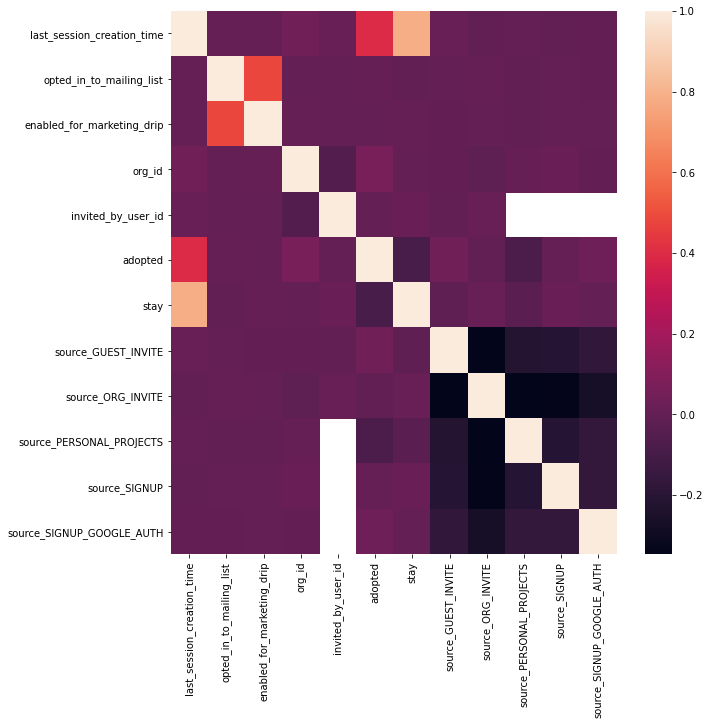

In [59]:
plt.figure(figsize = (10,10))
sns.heatmap(factors_encoded.corr())

most correlated with adopted is last session create time? others are org id and invited by guest?

In [60]:
def missing(df):
    '''Takes dataframe as argument, 
    returns count and % of missing values for each column'''
    import pandas as pd
    miss = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
    miss.columns = ['count','%']
    return miss.sort_values(by = ['count'], ascending = False)

In [63]:
missing(factors_encoded)

,count,%
invited_by_user_id,5583,46.525
last_session_creation_time,3177,26.475
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000
adopted,0,0.000
stay,0,0.000
source_GUEST_INVITE,0,0.000
source_ORG_INVITE,0,0.000
source_PERSONAL_PROJECTS,0,0.000


In [61]:
X = factors_encoded.drop(columns = 'adopted')
y = factors_encoded['adopted']

In [62]:
X.drop(columns = ['invited_by_user_id','last_session_creation_time'], inplace = True)

In [264]:
#X.isna()

In [64]:
y

0        0
1        1
2        0
3        0
4        0
        ..
11995    0
11996    0
11997    0
11998    0
11999    0
Name: adopted, Length: 12000, dtype: int64

In [65]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [66]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3, random_state = 123, stratify = y)

In [68]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [69]:
from sklearn.metrics import accuracy_score

In [70]:
preds = lr.predict(X_test)
acc = accuracy_score(preds,y_test)

In [71]:
acc

0.8663888888888889

In [72]:
lr.coef_

array([[ 0.02326676, -0.00462857,  0.18342922, -0.25891372,  0.10406646,
         0.01462809, -0.22890534,  0.00457482,  0.12024541]])

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
preds = rf.predict(X_test)

In [75]:
accuracy_score(preds,y_test)

0.8469444444444445

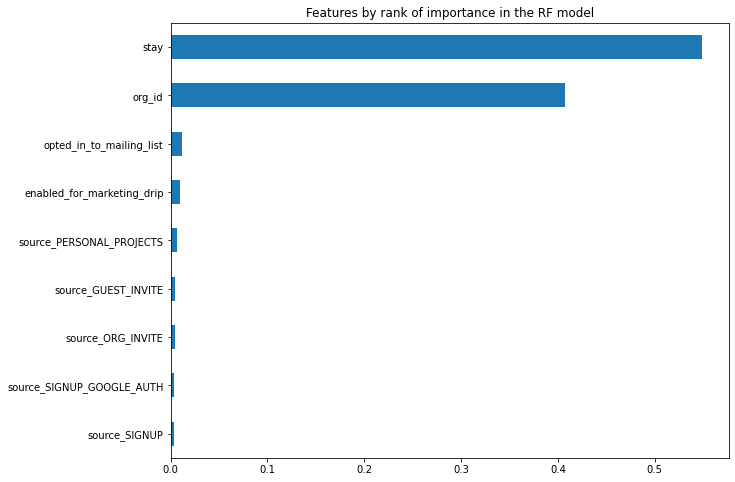

In [76]:
rf_features =  pd.Series(rf.feature_importances_, index = X.columns)

rf_features.sort_values().plot(kind='barh', figsize=(10,8))
plt.title('Features by rank of importance in the RF model')
plt.show()